Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

Load the dataset and add upvote metrics

In [2]:
odf = pd.read_csv('Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1, 'How helpful users find among user scores')

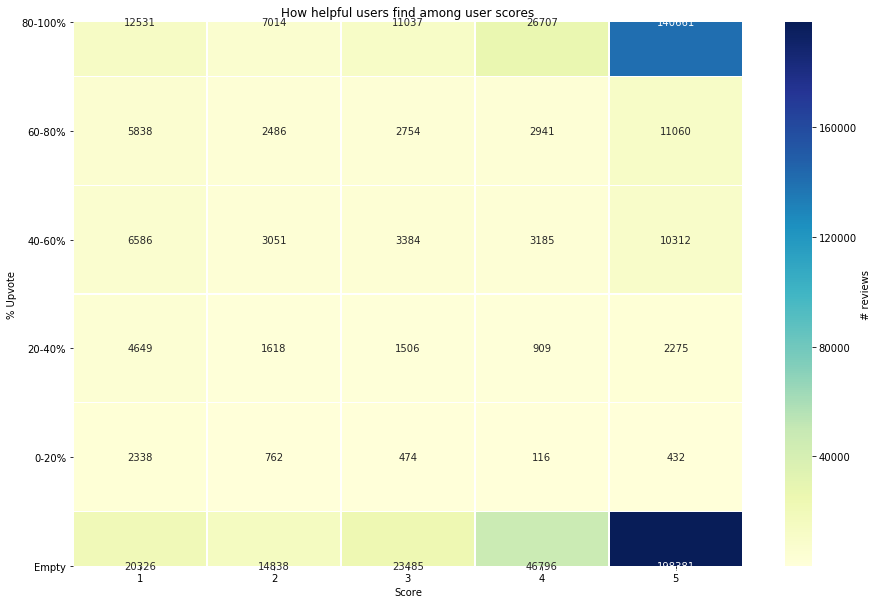

In [3]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Remove the score 3 reviews and seperate the remaining reviews into binary score

In [4]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

Logistic regression model on word count

In [5]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Accuracy: 0.9387998843701979

-Top 20 positive-
          Word  Coefficient
    pleasantly     3.328711
 emeraldforest     3.200839
       chedder     3.023067
       easiest     2.562891
       solving     2.454019
       blowout     2.446208
      heartier     2.372649
     addicting     2.370812
    unwrapping     2.299298
         herrs     2.297476
      drawback     2.292117
        hooked     2.290275
        skewed     2.286895
        hahaha     2.262377
      downside     2.249772
    correction     2.238950
         whisk     2.194644
        ration     2.189419
        bertie     2.188130
    dishwasher     2.167809

-Top 20 negative-
          Word  Coefficient
    unfinished    -2.465826
      tastless    -2.491598
       weakest    -2.599130
     overrated    -2.610019
     cancelled    -2.692715
   unappealing    -2.730364
       furious    -2.742493
    oversalted    -2.753004
     deceptive    -2.821840
 disappointing    -2.822400
   undrinkable    -2.825965
   

In [6]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7360597623503279


Logistic regression model on TFIDF

In [7]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9346691618360795

-Top 20 positive-
       Word  Coefficient
      great    13.722044
  delicious    12.152403
       best    12.013717
    perfect    10.606930
  excellent     9.860661
      loves     9.583118
     highly     9.037639
       love     8.363589
  wonderful     7.965186
    amazing     7.797095
    awesome     7.629207
       good     7.339743
 pleasantly     7.242569
       nice     7.188672
     hooked     7.019284
      yummy     6.954261
   favorite     6.941714
    pleased     6.931322
     smooth     6.884061
  fantastic     6.721710

-Top 20 negative-
           Word  Coefficient
          waste    -5.624627
           poor    -5.720375
    undrinkable    -5.722124
           yuck    -6.010275
          stale    -6.152046
          worse    -6.281936
          bland    -6.323421
     disgusting    -6.556101
           weak    -6.563131
         return    -6.688470
          threw    -6.733338
      tasteless    -6.838209
  unfortunately    -7.437

Logistic regression model on TFIDF + ngram

In [8]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9454714196601093

-Top 20 positive-
             Word  Coefficient
            great    21.054577
             best    17.831601
        delicious    17.012872
          perfect    14.624623
            loves    13.611160
             love    13.272387
        excellent    13.144334
             good    11.418326
        wonderful    11.321080
             nice    10.811514
         favorite    10.594919
          amazing     9.691426
          awesome     9.371318
             easy     9.143947
          pleased     8.947594
            happy     8.906614
           smooth     8.715677
            yummy     8.592553
           highly     8.466686
 highly recommend     8.423070

-Top 20 negative-
           Word  Coefficient
          maybe    -7.807009
         hoping    -8.129029
      tasteless    -8.250228
          money    -8.319548
          worse    -8.353005
        thought    -8.564717
     disgusting    -8.764723
          bland    -9.145294
          threw